This notebook: 
* loads the raw dataframe 
* split to train/val and get features and labels from the raw dataframe: 
    - split to train/val 
    - fit transformer on train, and apply on both train/val  
    - get the lookback period to the tensorflow input format 
* trains and compares different model classes 
    - mtclim 
    - 3 xgboost models
    - 4 lstm models 
    - 3 gru models  
    - 1 attention model 
    - ERA downscaled product 
    
TODO: 
* other models to try
    - compare to ERA


Future directions: 
* do transfer learning on streamflow prediction  
* do subdaily disaggregation or directly train on subdaily data 
* talk to andrew bennett about integrating into metsim (who embedded 2 way neural network in suma) 
* submit to JOSS (journal of open source software) read example https://joss.theoj.org/papers/10.21105/joss.02042 


Notes: 
* mtclim -> look for rain in past 90 days (can be a feature) 
* ERA has all the site information to do prediction (not out of sample), thus is likely an upperbound of prediction performance


In [1]:
!mamba install -y numpy==1.19 


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.2) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['numpy==1.19']

conda-forge/linux-64     Using cache
conda-forge/noarch       Using cache
Transacti

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import fsspec
import random
import xarray as xr
import matplotlib.pyplot as plt
from met_ml.train.features import train_test_split_based_on_lat, scale_data, get_features_and_labels
import met_ml.train.models as m

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score


FOLDER = '/home/jovyan/met-ml/data/'
random.seed(1)
random_state = 1

In [4]:
with fsspec.open(FOLDER + 'daily_data.csv') as f:
    df = pd.read_csv(f)

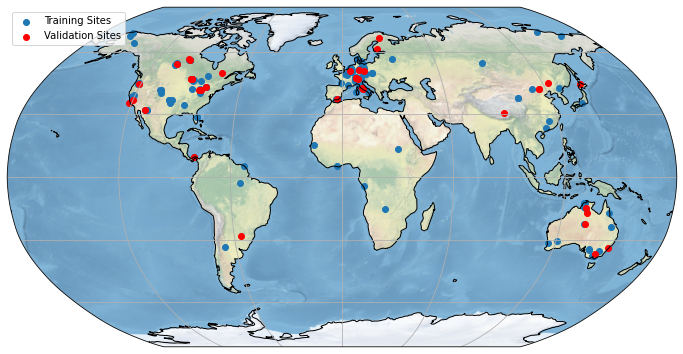

In [5]:
# get the training data 
lookback = 90

train, test = train_test_split_based_on_lat(
    data=df,
    test_size=0.2,
    random_state=random_state
)

scaled_train, scaled_test, scalers = scale_data(train, test)

X_train, Y_train, label_train = get_features_and_labels(scaled_train, lookback=lookback, input_is_2D=True)
_, unscaled_Y_train, _ = get_features_and_labels(train, lookback=lookback, input_is_2D=True)
X_test, Y_test, label_test = get_features_and_labels(scaled_test, lookback=lookback, input_is_2D=True)
_, unscaled_Y_test, _ = get_features_and_labels(test, lookback=lookback, input_is_2D=True)

# make sure the features are sorted in the same way 
assert np.all(X_train.features.values == X_test.features.values)
# make sure sample size is the same between X and Y 
assert len(X_train.samples) == len(Y_train.samples)
assert len(X_test.samples) == len(Y_test.samples)


In [6]:
len(X_train.samples)

114374

In [10]:
model_classes = [m.era, 
                 m.mtclim, 
                 m.attention_1_layer, 
                 m.gru_1_layer, m.gru_2_layer, m.gru_3_layer_wide, 
                 m.lstm_1_layer, m.lstm_2_layer, m.lstm_3_layer, m.lstm_3_layer_wide, 
                 m.xgb_default, m.xgb_hist, m.xgb_gpu_hist]
eval_func = {'mse': mean_squared_error, 'mae': mean_absolute_error, 'r2': r2_score, 'skill': explained_variance_score}

scores = []
for y_var in Y_train.features.values:
    print(y_var)
    y_train = Y_train.sel(features=y_var)
    y_test = Y_test.sel(features=y_var)
    for model_class in model_classes:
        model = model_class(variable=y_var, eval_func=eval_func)
        model.fit(X_train, y_train, X_test, y_test, folder=FOLDER, overwrite=False)
        model_score = model.evaluate(X_test, unscaled_Y_test.sel(features=y_var).values, label_test, scalers)
        model_score['model_name'] = model.name
        model_score['var'] = y_var
        model_score['split'] = 'test'
        scores.append(model_score)
        
        model_score = model.evaluate(X_train, unscaled_Y_train.sel(features=y_var).values, label_train, scalers)
        model_score['model_name'] = model.name
        model_score['var'] = y_var
        model_score['split'] = 'train'
        scores.append(model_score)
        
scores = pd.DataFrame(scores)

SW_IN
Building SW_IN_era model
Building SW_IN_mtclim model
    MTCLIM data for site RU-Che not available, skipping
    MTCLIM data for site RU-Cok not available, skipping
    MTCLIM data for site US-Ivo not available, skipping
    dropping 1929 samples due to nans
Building SW_IN_att_1_layer model
    model already exists, loading model
Building SW_IN_gru_1_layer model
    model already exists, loading model
Building SW_IN_gru_2_layer model
    model already exists, loading model
Building SW_IN_gru_3_layer_wide model
    model already exists, loading model
Building SW_IN_lstm_1_layer model
    model already exists, loading model
Building SW_IN_lstm_2_layer model
    model already exists, loading model
Building SW_IN_lstm_3_layer model
    model already exists, loading model
Building SW_IN_lstm_3_layer_wide model
    model already exists, loading model
Building SW_IN_xgb_default model
    model already exists, loading model
Building SW_IN_xgb_hist model
    model already exists, loading 

test performance


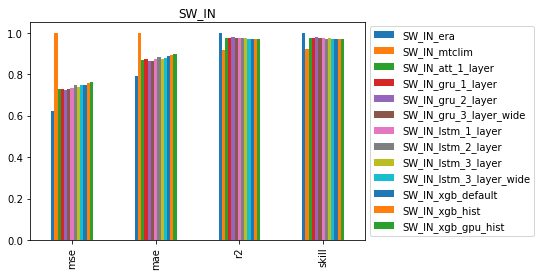

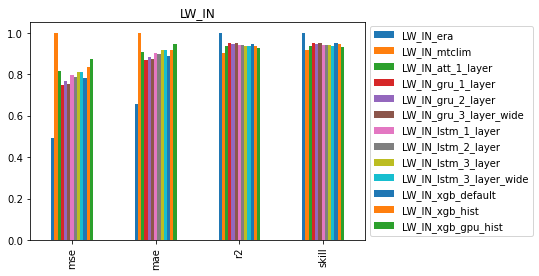

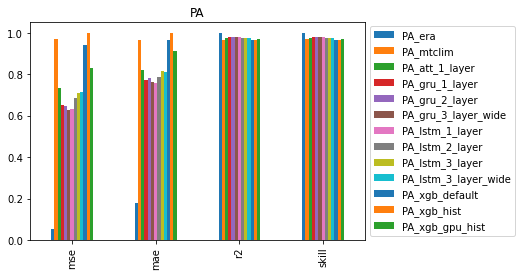

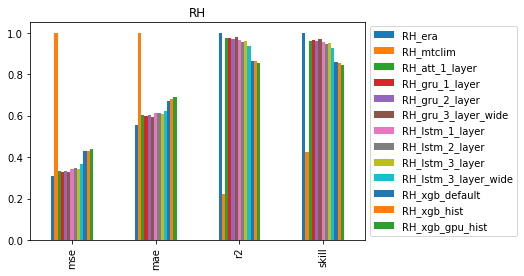

In [19]:
print('test performance')

for y_var in Y_train.features.values:
    sub = scores.loc[(scores['var'] == y_var) & (scores['split'] == 'test'), 
                     ['mse', 'mae', 'r2', 'skill', 'model_name']].set_index('model_name')
    sub /= sub.max()
    sub.T.plot.bar()
    plt.title(y_var)
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.show()
    plt.close()

In [15]:
for y_var in Y_train.features.values:
    print(y_var)
    print('----------------------------------------------------------------------------------------------')
    sub = scores.loc[(scores['var'] == y_var) & (scores['split'] == 'test'), 
                     ['mse', 'mae', 'r2', 'skill', 'model_name']].set_index('model_name')
    
    print('For MSE,   top 3 are: ', sub.sort_values(by='mse', ascending=True).head(3).index.to_list())
    print('For MAE,   top 3 are: ', sub.sort_values(by='mae', ascending=True).head(3).index.to_list())
    print('For R2,    top 3 are: ', sub.sort_values(by='r2', ascending=False).head(3).index.to_list())
    print('For skill, top 3 are: ', sub.sort_values(by='skill', ascending=False).head(3).index.to_list())
    print('')


SW_IN
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['SW_IN_era', 'SW_IN_gru_2_layer', 'SW_IN_gru_1_layer']
For MAE,   top 3 are:  ['SW_IN_era', 'SW_IN_gru_3_layer_wide', 'SW_IN_gru_2_layer']
For R2,    top 3 are:  ['SW_IN_era', 'SW_IN_gru_2_layer', 'SW_IN_gru_1_layer']
For skill, top 3 are:  ['SW_IN_era', 'SW_IN_gru_2_layer', 'SW_IN_att_1_layer']

LW_IN
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['LW_IN_era', 'LW_IN_gru_1_layer', 'LW_IN_gru_3_layer_wide']
For MAE,   top 3 are:  ['LW_IN_era', 'LW_IN_gru_1_layer', 'LW_IN_gru_3_layer_wide']
For R2,    top 3 are:  ['LW_IN_era', 'LW_IN_gru_1_layer', 'LW_IN_gru_3_layer_wide']
For skill, top 3 are:  ['LW_IN_era', 'LW_IN_xgb_default', 'LW_IN_gru_1_layer']

PA
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['PA_era', 'PA_gru_3_la

training performance


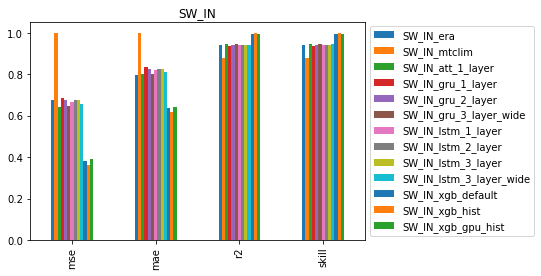

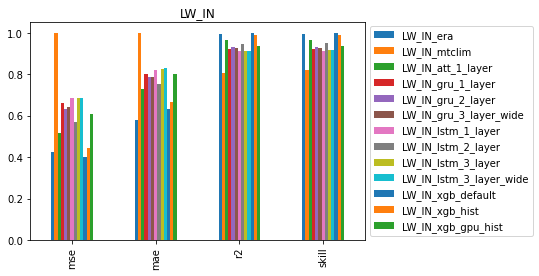

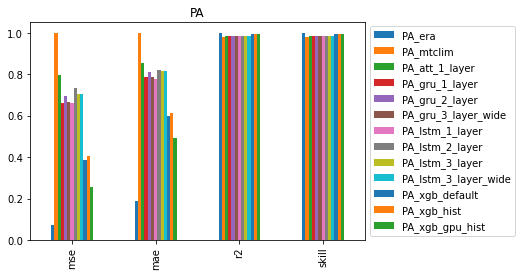

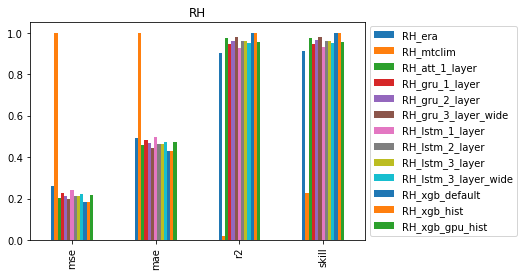

In [18]:
print('training performance')

for y_var in Y_train.features.values:
    sub = scores.loc[(scores['var'] == y_var) & (scores['split'] == 'train'), 
                     ['mse', 'mae', 'r2', 'skill', 'model_name']].set_index('model_name')
    sub /= sub.max()
    sub.T.plot.bar()
    plt.title(y_var)
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.show()
    plt.close()

In [17]:
for y_var in Y_train.features.values:
    print(y_var)
    print('----------------------------------------------------------------------------------------------')
    sub = scores.loc[(scores['var'] == y_var) & (scores['split'] == 'train'), 
                     ['mse', 'mae', 'r2', 'skill', 'model_name']].set_index('model_name')
    
    print('For MSE,   top 3 are: ', sub.sort_values(by='mse', ascending=True).head(3).index.to_list())
    print('For MAE,   top 3 are: ', sub.sort_values(by='mae', ascending=True).head(3).index.to_list())
    print('For R2,    top 3 are: ', sub.sort_values(by='r2', ascending=False).head(3).index.to_list())
    print('For skill, top 3 are: ', sub.sort_values(by='skill', ascending=False).head(3).index.to_list())
    print('')

SW_IN
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['SW_IN_xgb_hist', 'SW_IN_xgb_default', 'SW_IN_xgb_gpu_hist']
For MAE,   top 3 are:  ['SW_IN_xgb_hist', 'SW_IN_xgb_default', 'SW_IN_xgb_gpu_hist']
For R2,    top 3 are:  ['SW_IN_xgb_hist', 'SW_IN_xgb_default', 'SW_IN_xgb_gpu_hist']
For skill, top 3 are:  ['SW_IN_xgb_hist', 'SW_IN_xgb_default', 'SW_IN_xgb_gpu_hist']

LW_IN
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['LW_IN_xgb_default', 'LW_IN_era', 'LW_IN_xgb_hist']
For MAE,   top 3 are:  ['LW_IN_era', 'LW_IN_xgb_default', 'LW_IN_xgb_hist']
For R2,    top 3 are:  ['LW_IN_xgb_default', 'LW_IN_era', 'LW_IN_xgb_hist']
For skill, top 3 are:  ['LW_IN_xgb_default', 'LW_IN_era', 'LW_IN_xgb_hist']

PA
----------------------------------------------------------------------------------------------
For MSE,   top 3 are:  ['PA_era', 'PA_xgb_gpu_hist', '

train/test comparison


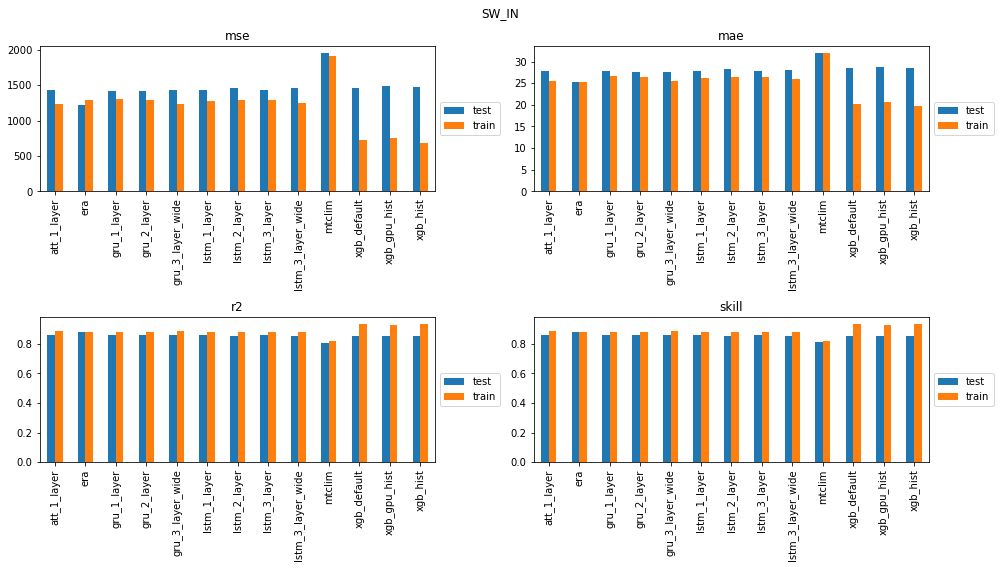

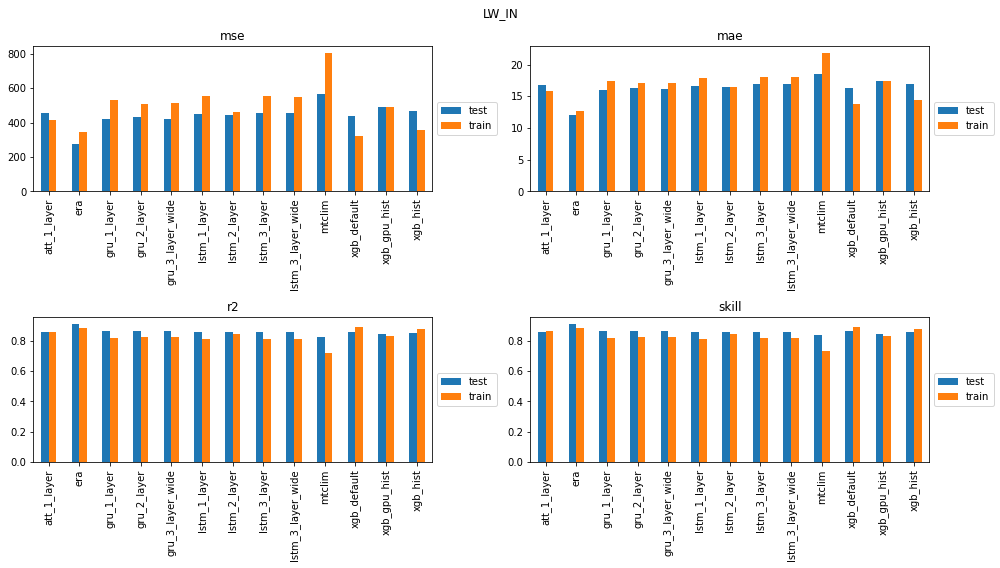

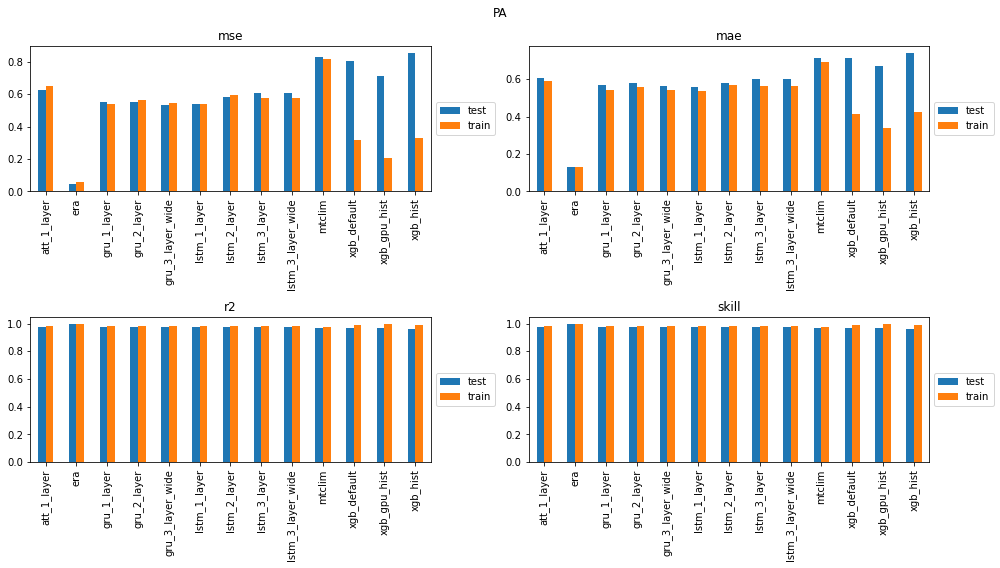

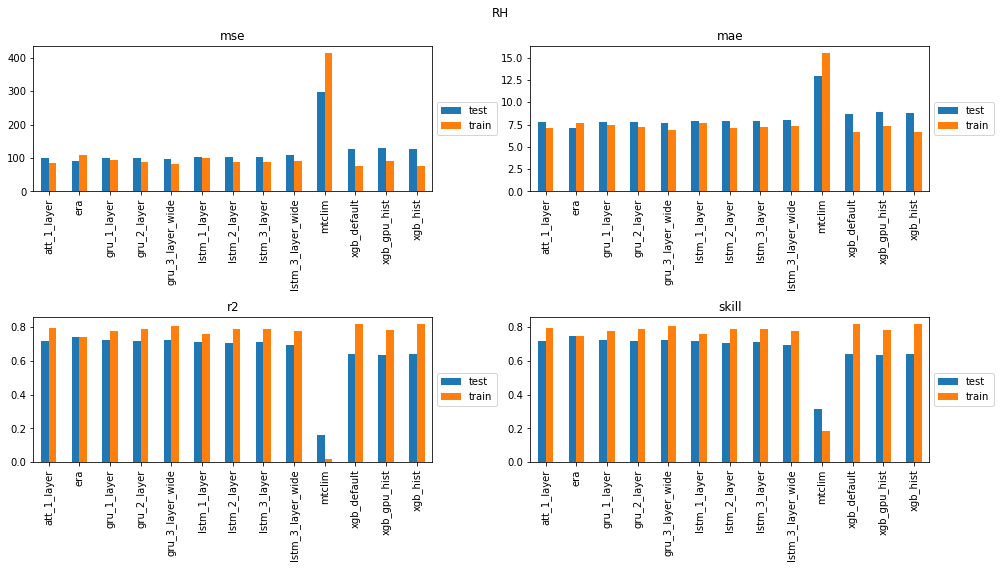

In [37]:
print('train/test comparison')

for y_var in Y_train.features.values:
    plt.figure(figsize=(14, 8))
    plt.suptitle(y_var)
    for i, metric in enumerate(['mse', 'mae', 'r2', 'skill']):
        sub = scores.loc[(scores['var'] == y_var), ['model_name', 'split', metric]].sort_values(by='model_name')
        sub['model_name'] = sub.model_name.str.replace(y_var+'_', '')
        plt.subplot(2, 2, i+1)
        ax = plt.gca()
        sub.pivot_table(values=metric, columns='split', index='model_name').plot.bar(ax=ax)
        plt.title(metric)
        plt.xlabel('')
        plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    
    plt.tight_layout()
    plt.show()
    plt.close()